In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import cm
from scipy.stats import norm
import pylab
import pandas as pd
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D
tf.compat.v1.disable_eager_execution()
import json

/Users/shankar/opt/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/shankar/opt/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/shankar/opt/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/shanka

In [2]:
dimension_state = 1

riskfree_rate = 0.05
volatility = 0.25
strike_price = 0.5

# Time limits
T_min = 0.
T_max  = 1.

# Space limits
S_min = 1e-10 
S_max = 1.

# Network parameters
nr_layers = 3
nr_nodes_per_layer = 50
initial_learning_rate = 0.001
learning_rate_decay_steps = 10000
learning_rate_decay_rate = 0.9

# Training parameters
steps_per_sample = 10
nr_epochs = 1000

# Number of samples
N_interior = 6500
N_initial = 6500

In [3]:
# DGM neural network model
class DNN(tf.keras.Model):#creating a class called DNN
    def __init__(self, nr_layers, nr_nodes_each_layer, state_dimension=1):#init is similiar to a constructor in c++
        #self allows you to call instances of that class similar to a this pointer.
        tf.keras.Model.__init__(self)#calls the parent constructor
        self.nr_layers = nr_layers #assinging member variables nr_layers as input varaible 

        self.initial_layer = DenseLayer(state_dimension + 1, nr_nodes_each_layer, activation=tf.nn.tanh)
        #setting parameters for initial layers start from 2(state dimension +time(1)) nodes all the way to 50 nodes
        self.hidden_layers = []
        for _ in range(nr_layers): #iterating over the 3 layers
            self.hidden_layers.append(LayerFromPaper(state_dimension + 1, nr_nodes_each_layer, activation=tf.nn.tanh))#appending the hidden layers create 3 of them
        self.final_layer = DenseLayer(nr_nodes_each_layer, 1, activation=None)#create the last layer


    def call(self, t, x):# creating of a member function
        X = tf.concat([t,x], 1) # concats the time and stock price in columns

        S = self.initial_layer.call(X)#call is a member function of dense layer
        for i in range(self.nr_layers):
            S = self.hidden_layers[i].call({'S': S, 'X': X})#creating the hidden layers, #X=time and asset price we concat this in  X = tf.concat([t,x], 1)
        result = self.final_layer.call(S)#creating the final layer

        return result
    


# Neural network layers

class DenseLayer(tf.keras.layers.Layer):# creating the class Dense layers
    def __init__(self, nr_inputs, nr_outputs, activation): #creating the constructor for that class
        tf.keras.layers.Layer.__init__(self)#initialzing the object of that class
        
        self.initializer = tf.keras.initializers.glorot_normal
        #self.initializer=tf.contrib.layers.xavier_initializer()) #TF 1

        self.nr_inputs = nr_inputs# initilaizing nr_inputs as a member variable
        self.nr_outputs = nr_outputs # initilizing nr_outputs as a member varaible
        
        self.W = self.add_variable("W", shape=[self.nr_inputs, self.nr_outputs],
                                   initializer=self.initializer())# initializing W as a member variable creating a matrix type object in order to train it for the neural network
        #W is one of the weights
        self.b = self.add_variable("b", shape=[1, self.nr_outputs])  #bias or constant added only at the end of training as therefore has no initilization

        self.activation = activation #saving it as a member variable
    
    
    def call(self, inputs):#member function of Dense Layer
        S = tf.add(tf.matmul(inputs, self.W), self.b) #From paper
        if not self.activation == None:
            S = self.activation(S) #activation function with the sigma (not volatility)

        return S



class LayerFromPaper(tf.keras.layers.Layer):
    def __init__(self, nr_inputs, nr_outputs, activation):
        tf.keras.layers.Layer.__init__(self)

        self.initializer = tf.keras.initializers.glorot_normal
        
        self.nr_outputs = nr_outputs
        self.nr_inputs = nr_inputs

        self.Uz = self.add_variable("Uz", shape=[self.nr_inputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Ug = self.add_variable("Ug", shape=[self.nr_inputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Ur = self.add_variable("Ur", shape=[self.nr_inputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Uh = self.add_variable("Uh", shape=[self.nr_inputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Wz = self.add_variable("Wz", shape=[self.nr_outputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Wg = self.add_variable("Wg", shape=[self.nr_outputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Wr = self.add_variable("Wr", shape=[self.nr_outputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Wh = self.add_variable("Wh", shape=[self.nr_outputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.bz = self.add_variable("bz", shape=[1, self.nr_outputs])
        self.bg = self.add_variable("bg", shape=[1, self.nr_outputs])
        self.br = self.add_variable("br", shape=[1, self.nr_outputs])
        self.bh = self.add_variable("bh", shape=[1, self.nr_outputs])

        self.activation = activation

    
    def call(self, inputs):
        S = inputs['S']
        X = inputs['X']

        Z = self.activation(tf.add(tf.add(tf.matmul(X, self.Uz), tf.matmul(S, self.Wz)), self.bz))
        G = self.activation(tf.add(tf.add(tf.matmul(X, self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.activation(tf.add(tf.add(tf.matmul(X, self.Ur), tf.matmul(S, self.Wr)), self.br))
        H = self.activation(tf.add(tf.add(tf.matmul(X, self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        Snew = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z, S))

        return Snew

In [4]:
# Loss function
def get_residual(model, t_interior, x_interior, t_initial, x_initial):#model =BS Model,t_interior=time from 0 to 1,
    #x_interior=stock price from min to max, t_initial =t_min, x_initial=S_min
    # Loss term #1: PDE
    V = model(t_interior, x_interior)# valuation of the neural network
    V_t = tf.gradients(V, t_interior)[0] # DV/DT
    V_x = tf.gradients(V, x_interior)[0] # DV/DS
    V_xx = tf.gradients(V_x, x_interior)[0] #D^2V/DS^2
    #black scholes formula
    f = -V_t + riskfree_rate * V -riskfree_rate*x_interior*V_x - 0.5*volatility**2 * x_interior**2 * V_xx

    L1 = tf.reduce_mean(tf.square(f)) #mean of the squared residuals, residuals of the PDE J(F) part 1
    #Payoff function
    payoff= tf.math.maximum(0.,tf.subtract(strike_price,x_interior))
    #L2 norm
    L2=tf.reduce_mean(tf.square(tf.math.maximum(0.,payoff-V)))#J(f) part 2
    #max deviation of L2
    Max_dev=tf.math.reduce_max(tf.math.maximum(0.,payoff-V))
    #min deviation of L2
    Min_dev=tf.math.reduce_min(tf.math.maximum(0.,payoff-V))
    # Loss term #3: initial/terminal condition
    L3 = tf.reduce_mean(tf.square(model(t_initial,x_initial) - tf.math.maximum(0., strike_price - x_initial))) # J(F) part 3

    return (Max_dev,L1,L2,L3)


In [5]:
#  Sampling
def get_monte_carlo_points(N_interior, N_initial):
    # Sampler #1: PDE domain
    t_interior = np.random.uniform(low=T_min - 0.5*(T_max - T_min),
                           high=T_max,
                           size=[N_interior,1])
    s_interior = np.random.uniform(low=S_min - (S_max - S_min)*0.5,
                           high=S_max + (S_max - S_min)*0.5,
                           size=[N_interior,1])
    #you take all the t and the state space
    
    # Sampler #2: initial/terminal condition
    t_initial = T_max * np.ones((N_initial,1)) #Terminal condition
    s_initial = np.random.uniform(low=S_min - (S_max - S_min)*0.5,
                           high=S_max + (S_max - S_min)*0.5,
                           size=[N_initial,1])
    
    return (t_interior, s_interior, t_initial, s_initial)

In [6]:
def get_Finite_Difference_results():
    Finite_Difference_results=pd.read_table("Time_valuated Option_Price.csv", sep=r',')
    Finite_Difference_results=Finite_Difference_results.drop('Stock/Time Prices',axis=1)
    Finite_Difference_results=Finite_Difference_results.drop(Finite_Difference_results.index[-1])
    Finite_Difference_results=Finite_Difference_results.rename(columns={'1.00E+00': 'T=1','8.89E-01' : 'T=0.88','7.78E-01' : 'T=0.77','6.67E-01' : 'T=0.66','5.56E-01' : 'T=0.55', '4.44E-01' : 'T=0.44','3.33E-01' : 'T=0.33','2.22E-01' : 'T=0.22','1.11E-01' : 'T=0.11', '0.001' : 'T=0'})
    cols = ['T=1', 'T=0.88', 'T=0.77', 'T=0.66','T=0.55','T=0.44','T=0.33','T=0.22','T=0.11','T=0']
    for col in cols:
        Finite_Difference_results[col]=Finite_Difference_results[col].astype(float)
    return Finite_Difference_results

In [7]:
nn_plot_list=[]
def nn_plots_results():
    max_error=0
    times_to_evaluate_error=np.linspace(T_min,T_max,10)
    for t in times_to_evaluate_error:
        tt = t*np.ones_like(xplot.reshape(-1,1))
    
        nn_plot, = sess.run([vplot_t],
                        feed_dict={tplot_t:tt, xplot_t:xplot.reshape(-1,1)})
        nn_plot_list.append(nn_plot,)
    
    return nn_plot_list

In [8]:
# Neural Network definition

model = DNN(nr_layers, nr_nodes_per_layer) #first time this model is constructed

t_interior_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name="time_interior") #allows you to fill it with numbers
x_interior_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, dimension_state), name="stock_prices_interior")
t_initial_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name="time_initial")#allows you to fill it with numbers
x_initial_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, dimension_state), name="stock_prices_initial")


Max_dev,residual_interior,residual_exterior,residual_initial= get_residual(model, t_interior_tf, x_interior_tf, t_initial_tf, x_initial_tf)
residual = residual_interior + residual_initial+(residual_exterior*1) #this residual is the combination of the L1 and L2 norm
# Optimizer parameters
nr_steps = tf.Variable(0, trainable=False) #very weird itertation counter, counts the no of optimization steps we took
learning_rate = tf.compat.v1.train.exponential_decay(initial_learning_rate, nr_steps,
                                           learning_rate_decay_steps, 
                                           learning_rate_decay_rate, staircase=True)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(residual) #defining the optimizer 
# gradient descent with a momemtum term. mizimised the residuals

# Plot tensors
tplot_t = tf.compat.v1.placeholder(tf.float32, [None,1], name="tplot_t") # We name to recover it later
xplot_t = tf.compat.v1.placeholder(tf.float32, [None,1], name="xplot_t")
vplot_t = tf.identity(model(tplot_t, xplot_t), name="vplot_t") # Trick for naming the trained model

# Train network!!
init_op = tf.compat.v1.global_variables_initializer()


# Training data holders
residuals_list_residual0_1=[]
residuals_list_residual1_1=[]
residuals_list_residual2_1=[]
residuals_list_residual3_1=[]
residuals_list_residual4_1=[]
residuals_list_MaxDev0_1=[]
residuals_list_MaxDev1_1=[]
residuals_list_MaxDev2_1=[]
residuals_list_MaxDev3_1=[]
residuals_list_MaxDev4_1=[]
residuals_list_L10_1=[]
residuals_list_L11_1=[]
residuals_list_L12_1=[]
residuals_list_L13_1=[]
residuals_list_L14_1=[]
residuals_list_L20_1=[]
residuals_list_L21_1=[]
residuals_list_L22_1=[]
residuals_list_L23_1=[]
residuals_list_L24_1=[]
residuals_list_L30_1=[]
residuals_list_L31_1=[]
residuals_list_L32_1=[]
residuals_list_L33_1=[]
residuals_list_L34_1=[]






Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
# before opening a tensorflow session, close the old one if possible
n=0
while n<5:
    try:
        sess.close()
    except NameError:
        pass 
    sess =  tf.compat.v1.Session()
###################################################L2 NORM is multiplied by 1#######################################
    sess.run(init_op)

    print(n)
    if n+1==1:print("This is the first run of the neural network")
    elif n+1==2:print("This is the second run of the neural network")
    elif n+1==3:print("This is the third run of the neural network")
    elif n+1==4:print("This is the fourth run of the neural network")
    elif n+1==5:print("This is the fifth run of the neural network")
    for epoch in range(nr_epochs):
        t_interior_mc, x_interior_mc, t_initial_mc, x_initial_mc = get_monte_carlo_points(N_interior, N_initial)

        for _ in range(steps_per_sample):
             Max_deviation,residual_value, residual_interior_value,residual_exterior_value,residual_initial_value, _ = \
                 sess.run([Max_dev,residual, residual_interior, residual_exterior,residual_initial, optimizer],
                          feed_dict = {t_interior_tf:t_interior_mc, x_interior_tf:x_interior_mc,
                                        t_initial_tf:t_initial_mc, x_initial_tf:x_initial_mc})
            

        if n==0:residuals_list_residual0_1.append(residual_value),residuals_list_MaxDev0_1.append(Max_deviation),residuals_list_L10_1.append(residual_interior_value),residuals_list_L20_1.append(residual_exterior_value),residuals_list_L30_1.append(residual_initial_value)
        elif n==1:residuals_list_residual1_1.append(residual_value),residuals_list_MaxDev1_1.append(Max_deviation),residuals_list_L11_1.append(residual_interior_value),residuals_list_L21_1.append(residual_exterior_value),residuals_list_L31_1.append(residual_initial_value)
        elif n==2:residuals_list_residual2_1.append(residual_value),residuals_list_MaxDev2_1.append(Max_deviation),residuals_list_L12_1.append(residual_interior_value),residuals_list_L22_1.append(residual_exterior_value),residuals_list_L32_1.append(residual_initial_value)
        elif n==3:residuals_list_residual3_1.append(residual_value),residuals_list_MaxDev3_1.append(Max_deviation),residuals_list_L13_1.append(residual_interior_value),residuals_list_L23_1.append(residual_exterior_value),residuals_list_L33_1.append(residual_initial_value)
        elif n==4:residuals_list_residual4_1.append(residual_value),residuals_list_MaxDev4_1.append(Max_deviation),residuals_list_L14_1.append(residual_interior_value),residuals_list_L24_1.append(residual_exterior_value),residuals_list_L34_1.append(residual_initial_value)

        if (not np.mod(epoch, 100)) or epoch+1==nr_epochs:
            print("Stage: {:04d}, Loss: {:e}, Maximum_Deviation: {:e}, L1: {:e}, L2: {:e}, L3: {:e}".format(
                epoch,residual_value,Max_deviation, residual_interior_value,residual_exterior_value,residual_initial_value) )
    n=n+1

0
This is the first run of the neural network
Stage: 0000, Loss: 1.684607e-01, Maximum_Deviation: 5.192348e-01, L1: 8.572467e-02, L2: 6.969140e-03, L3: 7.576689e-02
Stage: 0100, Loss: 3.363021e-04, Maximum_Deviation: 5.083621e-02, L1: 5.326798e-05, L2: 8.298566e-05, L3: 2.000485e-04
Stage: 0200, Loss: 1.364005e-04, Maximum_Deviation: 2.396119e-02, L1: 3.072300e-05, L2: 3.849167e-05, L3: 6.718581e-05
Stage: 0300, Loss: 1.029297e-04, Maximum_Deviation: 2.256376e-02, L1: 2.560358e-05, L2: 3.740401e-05, L3: 3.992215e-05
Stage: 0400, Loss: 9.319528e-05, Maximum_Deviation: 2.219260e-02, L1: 2.339438e-05, L2: 3.717095e-05, L3: 3.262995e-05
Stage: 0500, Loss: 8.660419e-05, Maximum_Deviation: 2.131718e-02, L1: 2.832398e-05, L2: 3.583916e-05, L3: 2.244105e-05
Stage: 0600, Loss: 8.431521e-05, Maximum_Deviation: 2.099293e-02, L1: 2.702606e-05, L2: 3.507777e-05, L3: 2.221137e-05
Stage: 0700, Loss: 8.933704e-05, Maximum_Deviation: 2.093101e-02, L1: 2.148682e-05, L2: 3.171762e-05, L3: 3.613260e-05
St

In [10]:
# Plot results
N = 41      # Points on plot grid

times_to_plot = [0*T_max, 0.33*T_max, 0.66*T_max, T_max]
tplot = np.linspace(T_min, T_max, N) # for surface plot
xplot = np.linspace(S_min, S_max, N)


In [11]:
print("The mean residuals from the run of 5 neural networks where L2 is multiplied by 1 is")
residual_mean_1=(residuals_list_residual0_1[-1]+residuals_list_residual1_1[-1]+residuals_list_residual2_1[-1]+residuals_list_residual3_1[-1]+residuals_list_residual4_1[-1])/5   
print(residual_mean_1)
print("The mean maximum deviation from the run of 5 neural networks where L2 is multiplied by 1 is")
max_deviation_mean_1=[(residuals_list_MaxDev0_1[-1]+residuals_list_MaxDev1_1[-1]+residuals_list_MaxDev2_1[-1]+residuals_list_MaxDev3_1[-1]+residuals_list_MaxDev4_1[-1])/5]
print(max_deviation_mean_1)
print("The mean L1 norm from the run of 5 neural networks where L1 is multiplied by 1 is ")
L1_mean_1=[(residuals_list_L10_1[-1]+residuals_list_L11_1[-1]+residuals_list_L12_1[-1]+residuals_list_L13_1[-1]+residuals_list_L14_1[-1])/5]
print(L1_mean_1)
print("The mean L2 norm from the run of 5 neural networks where L2 is multiplied by 1 is ")
L2_mean_1=[(residuals_list_L20_1[-1]+residuals_list_L21_1[-1]+residuals_list_L22_1[-1]+residuals_list_L23_1[-1]+residuals_list_L24_1[-1])/5]
print(L2_mean_1)
print("The mean L3 norm from the run of 5 neural networks where L3 is multiplied by 1 is ")
L3_mean_1=[(residuals_list_L30_1[-1]+residuals_list_L31_1[-1]+residuals_list_L32_1[-1]+residuals_list_L33_1[-1]+residuals_list_L34_1[-1])/5]
print(L3_mean_1)

The mean residuals from the run of 5 neural networks where L2 is multiplied by 1 is
8.304290240630507e-05
The mean maximum deviation from the run of 5 neural networks where L2 is multiplied by 1 is
[0.022293055057525636]
The mean L1 norm from the run of 5 neural networks where L1 is multiplied by 1 is 
[2.1943909814581275e-05]
The mean L2 norm from the run of 5 neural networks where L2 is multiplied by 1 is 
[3.584866935852915e-05]
The mean L3 norm from the run of 5 neural networks where L3 is multiplied by 1 is 
[2.5250320322811604e-05]


In [12]:
print("The standard deviation of the residuals from the run of the 5 neural networks is")
residual_std_residuals=np.std([residuals_list_residual0_1[-1],residuals_list_residual1_1[-1],residuals_list_residual2_1[-1],residuals_list_residual3_1[-1],residuals_list_residual4_1[-1]])
print(residual_std_residuals)
print("The standard deviation of the maximum deviation from the run of 5 neural networks where L2 is multiplied by 1 is")
residual_std_max_deviation=np.std([residuals_list_MaxDev0_1[-1],residuals_list_MaxDev1_1[-1],residuals_list_MaxDev2_1[-1],residuals_list_MaxDev3_1[-1],residuals_list_MaxDev4_1[-1]])
print(residual_std_max_deviation)
print("The standard deviation of the L1 norm from the run of 5 neural networks where L1 is multiplied by 1 is ")
residual_std_L1=np.std([residuals_list_L10_1[-1],residuals_list_L11_1[-1],residuals_list_L12_1[-1],residuals_list_L13_1[-1],residuals_list_L14_1[-1]])
print(residual_std_L1)
print("The standard deviation of the L2 norm from the run of 5 neural networks where L2 is multiplied by 1 is ")
residual_std_L2=np.std([residuals_list_L20_1[-1],residuals_list_L21_1[-1],residuals_list_L22_1[-1],residuals_list_L23_1[-1],residuals_list_L24_1[-1]])
print(residual_std_L2)
print("The standards deviation of the L3 norm from the run of 5 neural networks where L3 is multiplied by 1 is ")
residual_std_L3=np.std([residuals_list_L30_1[-1],residuals_list_L31_1[-1],residuals_list_L32_1[-1],residuals_list_L33_1[-1],residuals_list_L34_1[-1]])
print(residual_std_L3)


The standard deviation of the residuals from the run of the 5 neural networks is
1.5083677e-05
The standard deviation of the maximum deviation from the run of 5 neural networks where L2 is multiplied by 1 is
0.00077041663
The standard deviation of the L1 norm from the run of 5 neural networks where L1 is multiplied by 1 is 
5.380922e-06
The standard deviation of the L2 norm from the run of 5 neural networks where L2 is multiplied by 1 is 
6.0759535e-06
The standards deviation of the L3 norm from the run of 5 neural networks where L3 is multiplied by 1 is 
1.5998769e-05


In [13]:
stats=[]
stats.append({"The mean residuals from the run of 5 neural networks where L2 is multiplied by 1 is":residual_mean_1})
stats.append({"The mean maximum deviation from the run of 5 neural networks where L2 is multiplied by 1 is":max_deviation_mean_1})
stats.append({"The mean L1 norm from the run of 5 neural networks where L1 is multiplied by 1 is ":L1_mean_1})
stats.append({"The mean L2 norm from the run of 5 neural networks where L2 is multiplied by 1 is ":L2_mean_1})
stats.append({"The mean L3 norm from the run of 5 neural networks where L3 is multiplied by 1 is ":L3_mean_1})
stats.append({"The standard deviation of the residuals from the run of the 5 neural networks where L2 is multiplied by 1 is:":residual_std_residuals})
stats.append({"The standard deviation of the maximum deviation from the run of 5 neural networks where L2 is multiplied by 1 is":residual_std_max_deviation})
stats.append({"The standard deviation of the L1 norm from the run of 5 neural networks where L1 is multiplied by 1 is ":residual_std_L1})
stats.append({"The standard deviation of the L2 norm from the run of 5 neural networks where L2 is multiplied by 1 is ":residual_std_L2})
stats.append({"The standards deviation of the L3 norm from the run of 5 neural networks where L3 is multiplied by 1 is ":residual_std_L3})
np.savetxt("L2_norm_stats_low_samples_put_options.txt", stats, delimiter=" ", newline = "\n", fmt="%s")

In [14]:
nn_plot_list=nn_plots_results()
nn_plot_container = np.transpose(np.reshape(nn_plot_list,(-1,41)))
nn_plots = pd.DataFrame(nn_plot_container)
nn_plots=nn_plots.rename(columns={0: 'T=0',1 : 'T=0.11',2 : 'T=0.22',3 : 'T=0.33',4 : 'T=0.44',5 : 'T=0.55',6 : 'T=0.66',7 : 'T=0.77',8 : 'T=0.88',9 : 'T=1'})
nn_plots[nn_plots < 0] = 0.000
print(nn_plots)


         T=0    T=0.11    T=0.22    T=0.33    T=0.44    T=0.55    T=0.66  \
0   0.490186  0.492179  0.494134  0.496050  0.497926  0.499773  0.501608   
1   0.465355  0.467368  0.469347  0.471288  0.473188  0.475053  0.476895   
2   0.440580  0.442595  0.444577  0.446520  0.448420  0.450280  0.452108   
3   0.415818  0.417821  0.419786  0.421709  0.423586  0.425419  0.427213   
4   0.391027  0.393006  0.394938  0.396824  0.398661  0.400449  0.402195   
5   0.366164  0.368115  0.370008  0.371847  0.373632  0.375367  0.377057   
6   0.341192  0.343121  0.344978  0.346771  0.348505  0.350186  0.351825   
7   0.316084  0.318003  0.319836  0.321596  0.323292  0.324934  0.326537   
8   0.290828  0.292751  0.294580  0.296329  0.298010  0.299640  0.301238   
9   0.265436  0.267368  0.269210  0.270972  0.272670  0.274324  0.275957   
10  0.239957  0.241886  0.243740  0.245530  0.247270  0.248983  0.250696   
11  0.214502  0.216380  0.218215  0.220017  0.221799  0.223586  0.225407   
12  0.189270

In [15]:
Finite_Difference_results=get_Finite_Difference_results()
Finite_Difference_results=Finite_Difference_results.astype('float64')
val_diff=np.abs(nn_plots-Finite_Difference_results.values)
print(val_diff)
mean_error_container=[]
cols = ['T=1', 'T=0.88', 'T=0.77', 'T=0.66','T=0.55','T=0.44','T=0.33','T=0.22','T=0.11','T=0']
print("The maximum error of the neural network when compared to the finite difference method is", np.max(val_diff[cols].max(axis=0)))
mean_error_container.append(np.mean(val_diff[cols].mean(axis=0)))
print("The mean error of the neural network when compared to the finite difference method is", mean_error_container)

         T=0    T=0.11    T=0.22    T=0.33    T=0.44    T=0.55    T=0.66  \
0   0.009814  0.007821  0.005866  0.003950  0.002074  0.000227  0.001608   
1   0.009645  0.007632  0.005653  0.003712  0.001812  0.000053  0.001895   
2   0.009420  0.007405  0.005423  0.003480  0.001580  0.000280  0.002108   
3   0.009182  0.007179  0.005214  0.003291  0.001414  0.000419  0.002213   
4   0.008973  0.006994  0.005062  0.003176  0.001339  0.000449  0.002195   
5   0.008836  0.006885  0.004992  0.003153  0.001368  0.000367  0.002057   
6   0.008808  0.006879  0.005022  0.003229  0.001495  0.000186  0.001825   
7   0.008916  0.006997  0.005164  0.003404  0.001708  0.000066  0.001537   
8   0.009172  0.007249  0.005420  0.003671  0.001990  0.000360  0.001238   
9   0.009564  0.007632  0.005790  0.004028  0.002330  0.000676  0.000957   
10  0.010043  0.008114  0.006260  0.004470  0.002730  0.001017  0.000696   
11  0.010498  0.008620  0.006785  0.004983  0.003201  0.001414  0.000407   
12  0.010730

Text(0.5, 0, 'Option_Price')

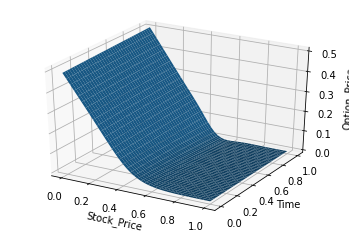

In [16]:
x_grid, t_grid = np.meshgrid(xplot, tplot, sparse=False, indexing='ij')
nn_plot = sess.run(vplot_t,
                    feed_dict={tplot_t:t_grid.reshape(-1,1),
                               xplot_t:x_grid.reshape(-1,1)}).reshape(N,N)

fig = pylab.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X=x_grid, Y=t_grid, Z=nn_plot)
ax.set_xlabel('Stock_Price')
ax.set_ylabel('Time')
ax.set_zlabel('Option_Price')


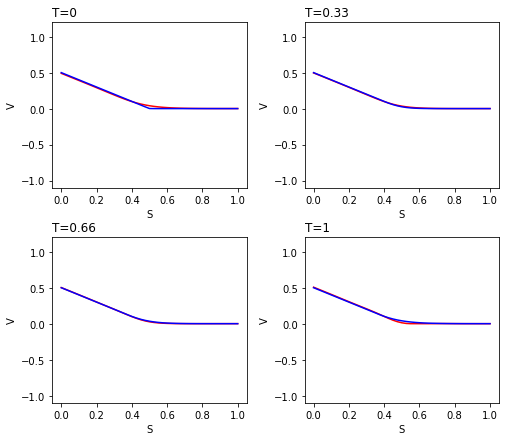

In [28]:
plt.figure(figsize=(8,7))
results=get_Finite_Difference_results()
i = 1
for column in nn_plots[['T=0', 'T=0.33', 'T=0.66', 'T=1']]:
    nn_plot = nn_plots[column].values
    Finite_results=results[column].values
    plt.subplot(2,2,i)
    plt.plot(xplot, nn_plot, 'r')
    plt.plot(xplot, Finite_results, 'b')

    plt.ylim(-1.1, 1.2)
    plt.xlabel("S")
    plt.ylabel("V")
    plt.title(column, loc="left")
    i = i+1

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('L2*1_comparison_put_option_low_samples.png', dpi=100, bbox_inches='tight')
plt.show()

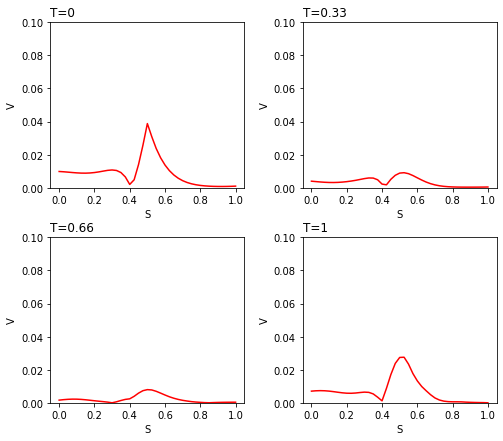

In [29]:
plt.figure(figsize=(8,7))
results=get_Finite_Difference_results()
i = 1
for column in nn_plots[['T=0', 'T=0.33', 'T=0.66', 'T=1']]:
    nn_plot = nn_plots[column].values
    Finite_results=results[column].values
    plt.subplot(2,2,i)
    plt.plot(xplot, abs((nn_plot-Finite_results)), 'r')

    plt.ylim(0, 0.1)
    plt.xlabel("S")
    plt.ylabel("V")
    plt.title(column, loc="left")
    i = i+1

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('L2*1_error_put_option_low_samples.png', dpi=100, bbox_inches='tight')
plt.show()